# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from HANKModel import HANKModelClass

# Setup

In [2]:
model = HANKModelClass(name='baseline')

In [3]:
par = model.par
ss = model.ss
path = model.path
sim = model.sim

# Test Household Problem

In [4]:
# just some ad hoc parameters
par.beta = 0.96**(1/4)
ss.ra = 1.02**(1/4)-1
ss.w = 1.0
ss.L = 1.0
ss.tau = 0.10
ss.chi = 0.0

In [5]:
model.solve_hh_ss(do_print=True)
model.simulate_hh_ss(do_print=True)

household problem in ss solved in 1.5 secs [1007 iterations]
household problem in ss simulated in 4.2 secs [1307 iterations]


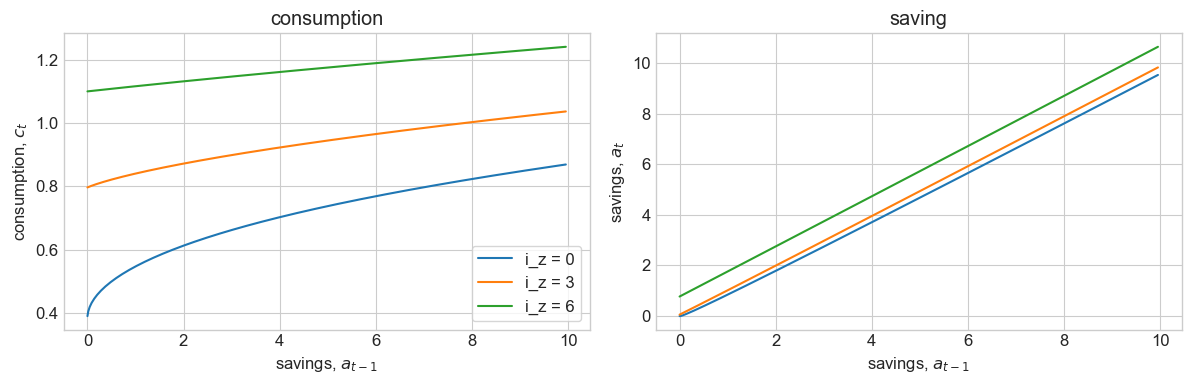

In [6]:
fig = plt.figure(figsize=(18,4),dpi=100)
a_max = 10

# a. consumption
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,1)
ax.set_title(f'consumption')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.c[0,i_z,I],label=f'i_z = {i_z}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# b. saving
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,2)
ax.set_title(f'saving')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.a[0,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings, $a_{t}$')

fig.tight_layout()

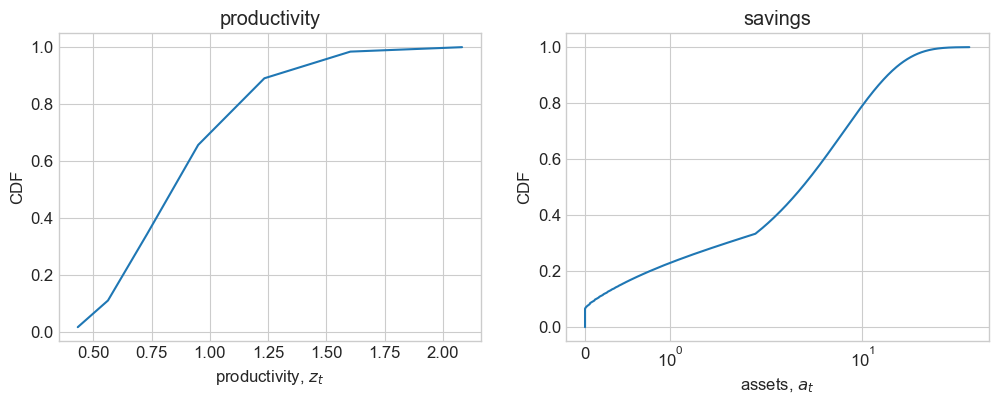

In [7]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('productivity')

y = np.cumsum(np.sum(ss.D[0],axis=1))
ax.plot(par.z_grid,y/y[-1])

ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')

# b. assets
ax = fig.add_subplot(1,2,2)
ax.set_title('savings')
y = np.insert(np.cumsum(np.sum(ss.D[0],axis=0)),0,0.0)
ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),y/y[-1])
        
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')

# Test household path

note: inputs = steady state value -> expected: constant value (straigt line)

household problem solved along transition path in 0.3 secs
household problem simulated along transition in 1.2 secs



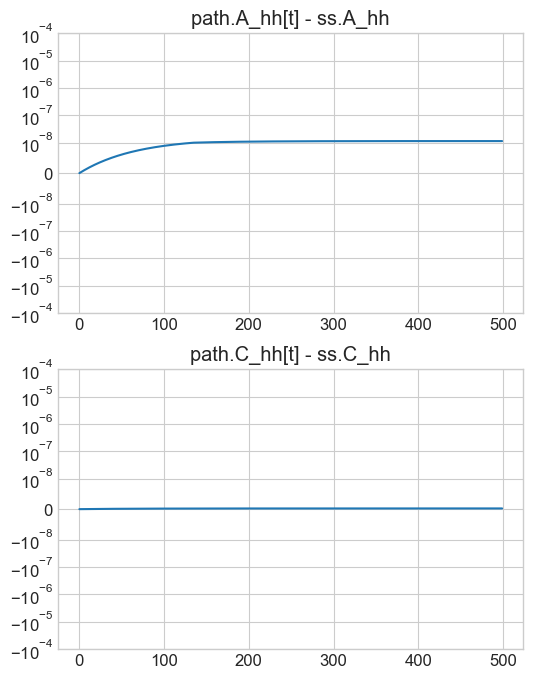

In [8]:
model.test_hh_path()

# Test steady state

In [9]:
from steady_state import obj_ss

In [10]:
beta_vec = np.linspace(0.85**(1/4),1/(1+par.r_target_ss)-1e-4,5)
clearing_A_vec = np.zeros(beta_vec.size)
for i,beta in enumerate(beta_vec):
    clearing_A_vec[i] = obj_ss(beta,model,do_print=False)
    print(f'{beta = :.3f} = {clearing_A_vec[i] = :.2f}')

beta = 0.960 = clearing_A_vec[i] = 0.79
beta = 0.969 = clearing_A_vec[i] = 0.53
beta = 0.978 = clearing_A_vec[i] = -0.10
beta = 0.986 = clearing_A_vec[i] = -2.01
beta = 0.995 = clearing_A_vec[i] = -30.47


In [11]:
model.find_ss(do_print=True)

steady state found in 2.9 secs
 r     =   0.0050
 q     =   4.8789
 qB    =   1.0000
varphi =   1.0352
beta   =   0.9767
Discrepancy in A =   0.00000000
Discrepancy in Y =   0.00000000


In [12]:
# Make table of steady state
import pandas as pd
varlist = ['C_hh','Y', 'L','tau','B','q','pi','i','ra','G','chi']

def g_dataframe(model,varlist=varlist):
    dict = {var: getattr(model.ss,var) for var in varlist}
    return pd.DataFrame.from_dict(dict,orient='index')

In [13]:
df = g_dataframe(model)
df = df.T.copy()
pct_vars = ['pi','i','ra']

for var in pct_vars:
    df[var]= (df[var] *100).map(lambda x: f'{x:.2f}\%')


df.rename(columns={
        'C_hh':'$\int c^{*}_{ss} d\mathbf{D}_{ss}$',
        'tau':'$\\tau$',
        'pi':'$\pi$',
        'ra':'$r^{a}$',
        'chi':'$\chi$'},inplace=True)


df.index =['ss']

df

,$\int c^{*}_{ss} d\mathbf{D}_{ss}$,Y,L,$\tau$,B,q,$\pi$,i,$r^{a}$,G,$\chi$
ss,0.8,1.0,1.0,0.204963,0.204963,4.878931,0.00\%,0.50\%,0.50\%,0.2,0.0


In [14]:
df_style = df.style.format(precision= 3)
df_style.to_latex(r'output\tab_ss.tex',hrules=True,column_format='l'+'c'*len(varlist))

df_style.to_latex(r'C:\Users\hms467\Dropbox\Apps\Overleaf\AMHA_A2_HANK\input\tab_ss.tex',hrules=True,column_format='l'+'c'*len(varlist))


# Test path

In [15]:
model.test_path()

note: inputs = steady state value -> expected: no difference to steady state and zero errors

difference to value at steady state:
A              : t0 =  0.0e+00, max abs.  0.0e+00
B              : t0 =  0.0e+00, max abs.  0.0e+00
chi            : t0 =  0.0e+00, max abs.  0.0e+00
clearing_A     : t0 = -3.4e-14, max abs.  2.7e-10
clearing_Y     : t0 =  0.0e+00, max abs.  0.0e+00
G              : t0 =  0.0e+00, max abs.  0.0e+00
Gamma          : t0 =  0.0e+00, max abs.  0.0e+00
i              : t0 =  0.0e+00, max abs.  0.0e+00
L              : t0 =  0.0e+00, max abs.  0.0e+00
NKWPC_res      : t0 =  8.7e-15, max abs.  3.8e-12
pi_w           : t0 =  0.0e+00, max abs.  0.0e+00
pi             : t0 =  0.0e+00, max abs.  0.0e+00
q              : t0 =  0.0e+00, max abs.  0.0e+00
r              : t0 =  0.0e+00, max abs.  0.0e+00
ra             : t0 =  0.0e+00, max abs.  0.0e+00
tau            : t0 =  0.0e+00, max abs.  0.0e+00
w              : t0 =  0.0e+00, max abs.  0.0e+00
Y              : t0

note: differences should only be due to numerical errors

direct method:
finding Jacobian wrt. ghost          : 0 125 250 375 [computed in 0.6 secs]
finding Jacobian wrt. L              : 0 125 250 375 [computed in 0.5 secs]
finding Jacobian wrt. chi            : 0 125 250 375 [computed in 0.4 secs]
finding Jacobian wrt. ra             : 0 125 250 375 [computed in 0.4 secs]
finding Jacobian wrt. tau            : 0 125 250 375 [computed in 0.5 secs]
finding Jacobian wrt. w              : 0 125 250 375 [computed in 0.5 secs]
household Jacobian computed in 3.1 secs

fake news method:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for L               in 0.2 secs
curly_Y and curly_D calculated for chi             in 0.2 secs
curly_Y and curly_D calculated for ra              in 0.2 secs
curly_Y and curly_D calculated for tau             in 0.2 secs
curly_Y and curly_D calculated for w               in 0.2 secs
curly_E calculated in 1.5 secs
builid

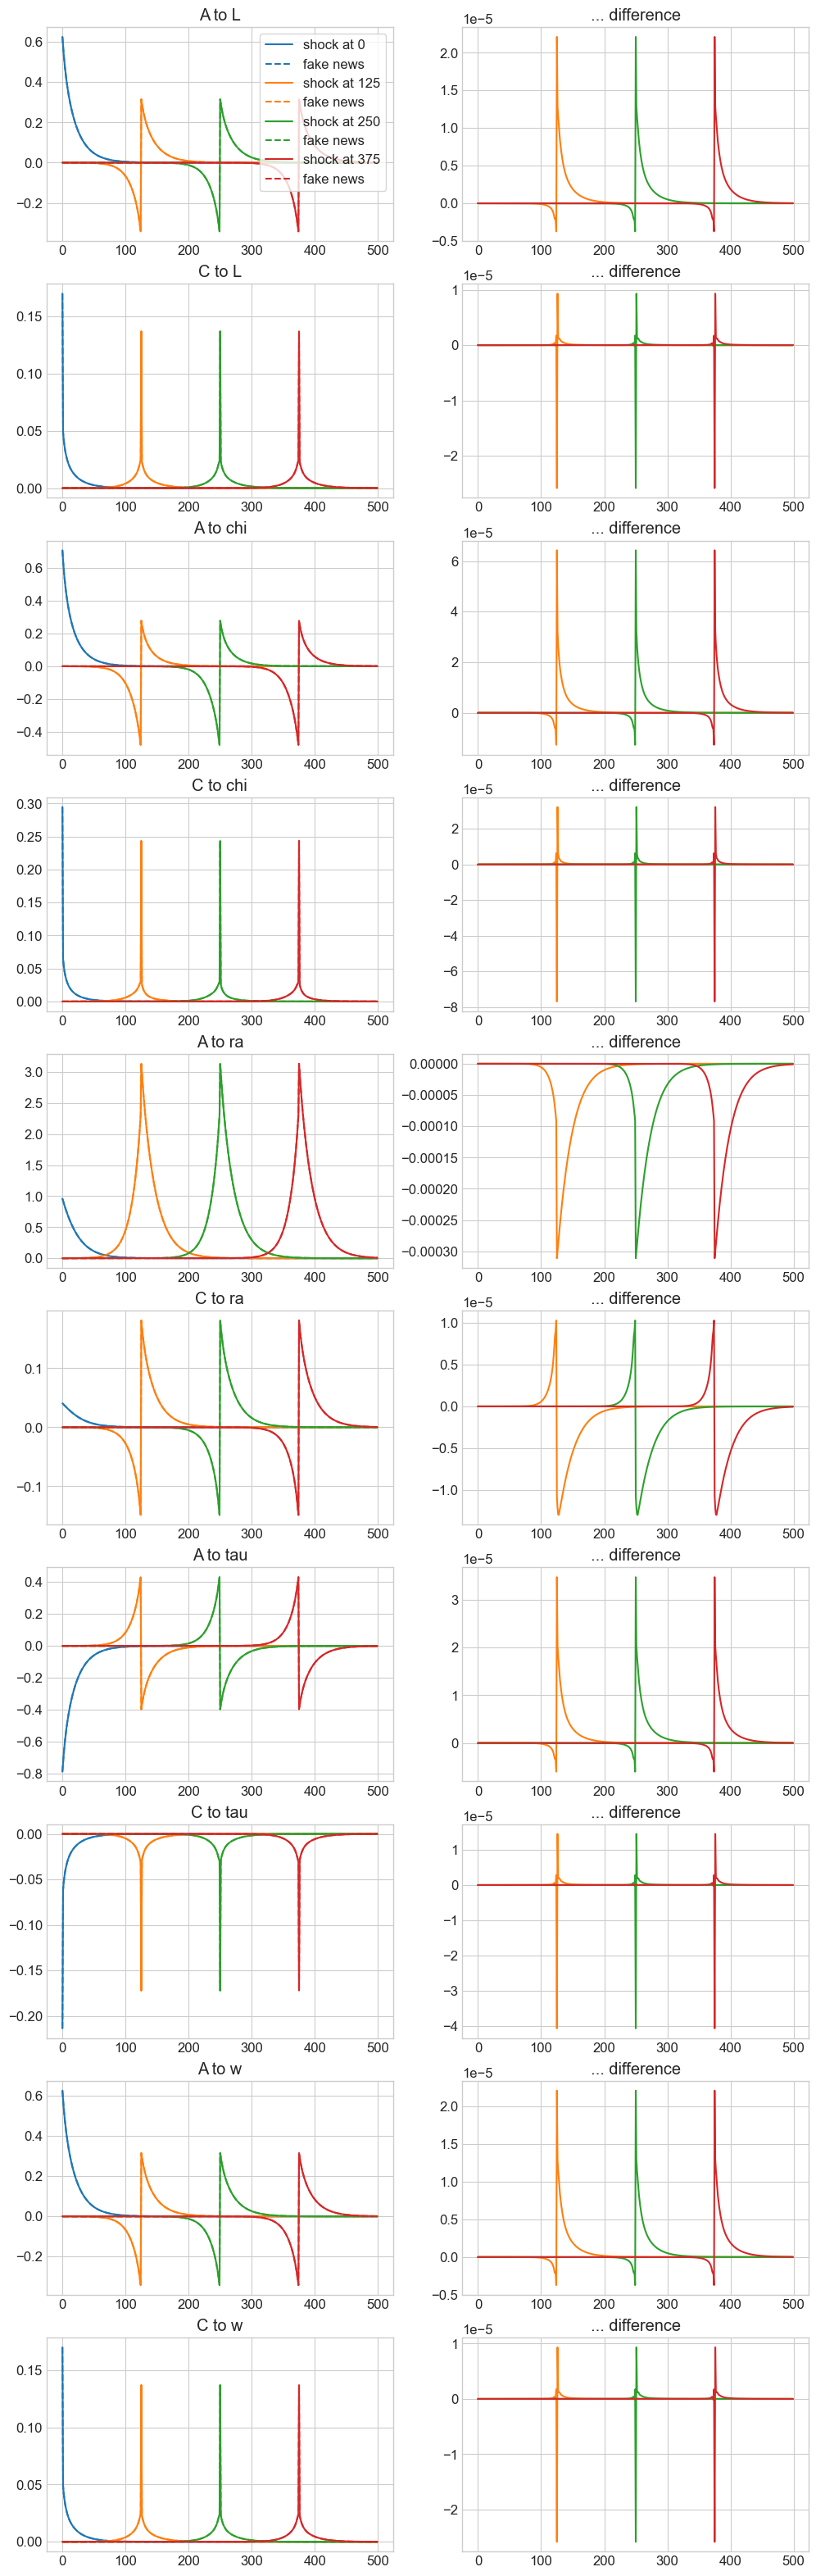

In [16]:
model.test_jacs()

# Question 1

In [17]:
model.ss.G*0.01

0.002

In [18]:
model.par.jump_G = 0.01*ss.G
model.par.rho_G = 0.8

# Just to make sure, when jumping forewards and back
model.par.jump_chi = 0.0
model.par.rho_chi = 0.0

model.find_transition_path(do_print=True)

finding the transition path:
 it =   0 -> max. abs. error = 1.52e-02
   1.79e-03 in NKWPC_res
   1.52e-02 in clearing_A
 it =   1 -> max. abs. error = 6.65e-05
   9.37e-06 in NKWPC_res
   6.65e-05 in clearing_A
 it =   2 -> max. abs. error = 1.06e-06
   7.52e-08 in NKWPC_res
   1.06e-06 in clearing_A
 it =   3 -> max. abs. error = 1.91e-09
   1.54e-10 in NKWPC_res
   1.91e-09 in clearing_A
 it =   4 -> max. abs. error = 2.29e-12
   3.45e-13 in NKWPC_res
   2.29e-12 in clearing_A

transition path found in 1.4 secs


In [19]:
model.find_IRFs(do_print=True)

linear transition path found in 0.1 secs [finding solution matrix: 0.1 secs]


### shocks ###


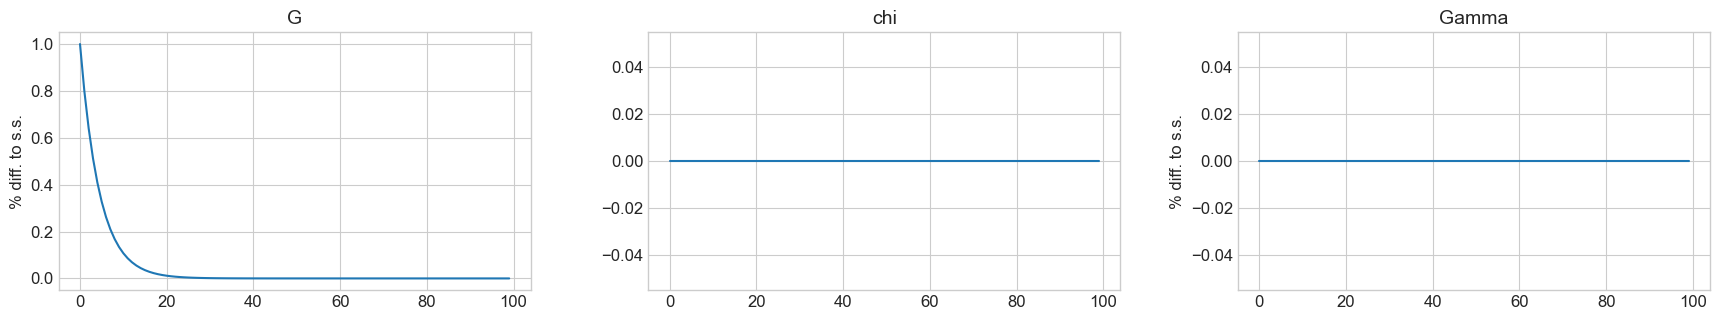


### varnames ###


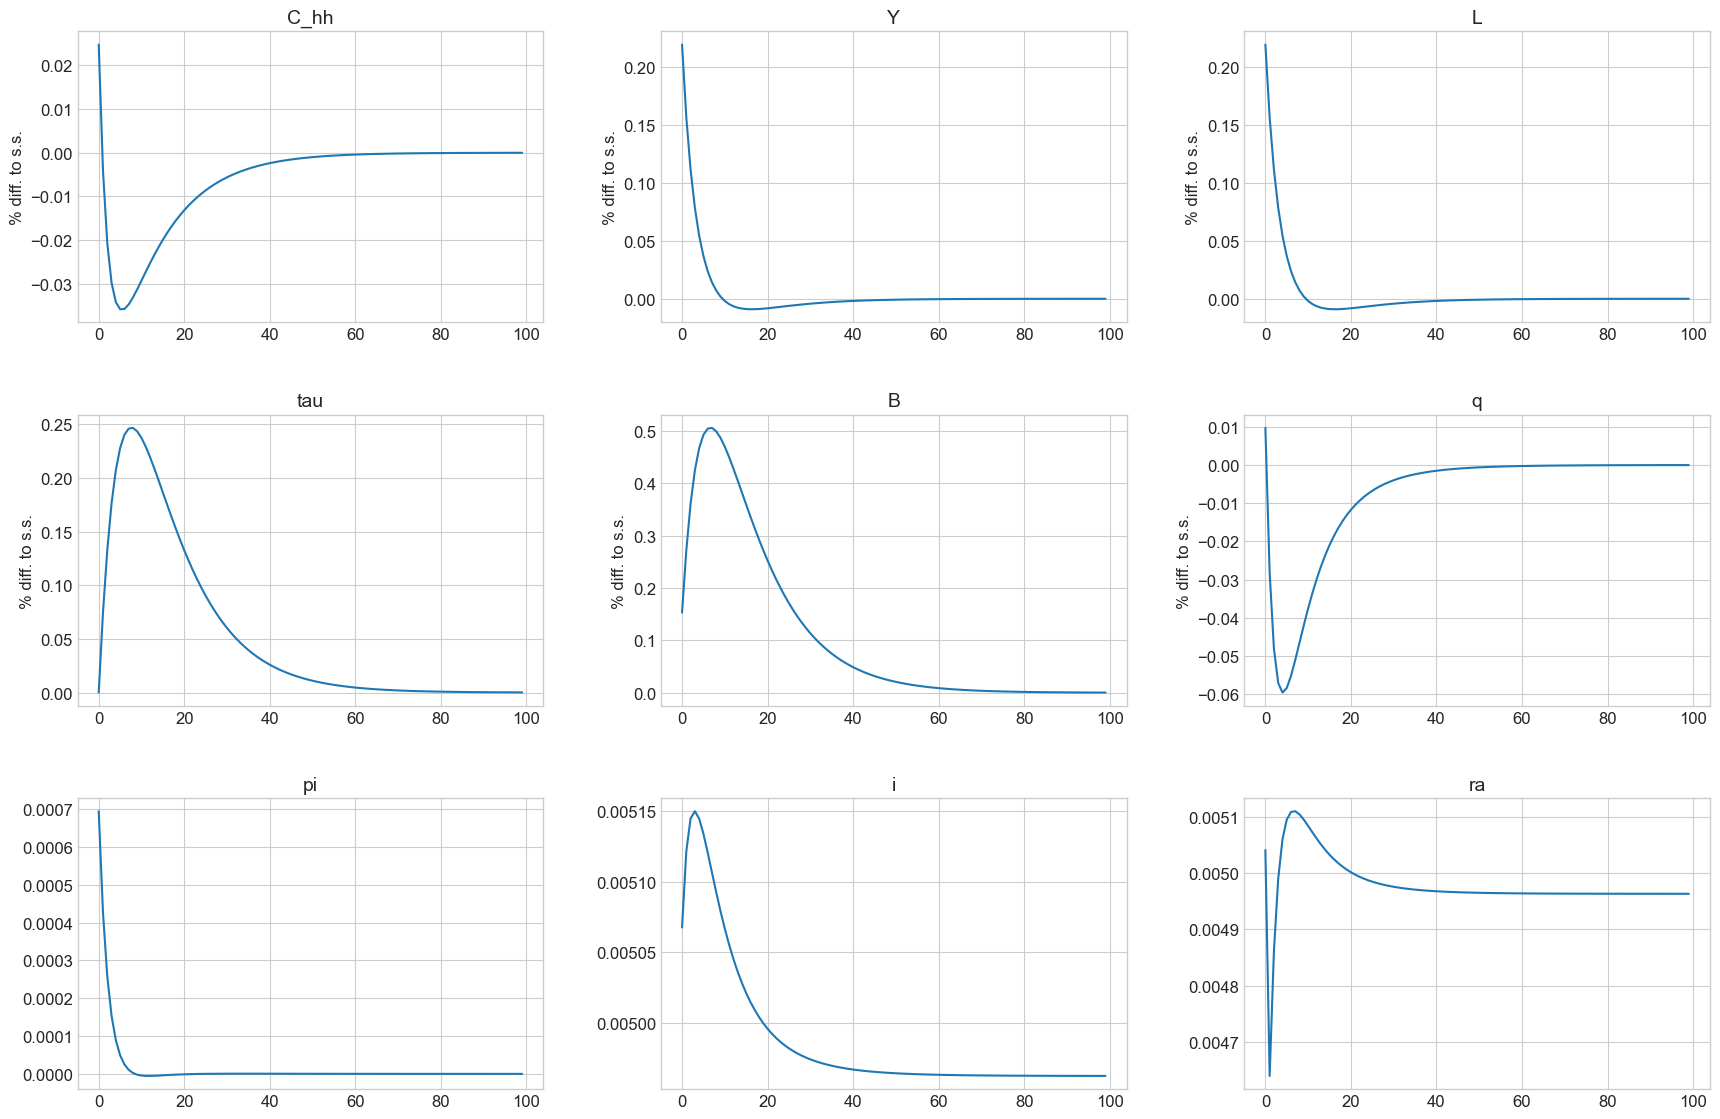


### tagets ###


c:\Users\hms467\Anaconda3\lib\site-packages\GEModelTools\figures.py:109: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(np.arange(T_max),100*(pathvalue[:T_max]/ssvalue-1),label=label)


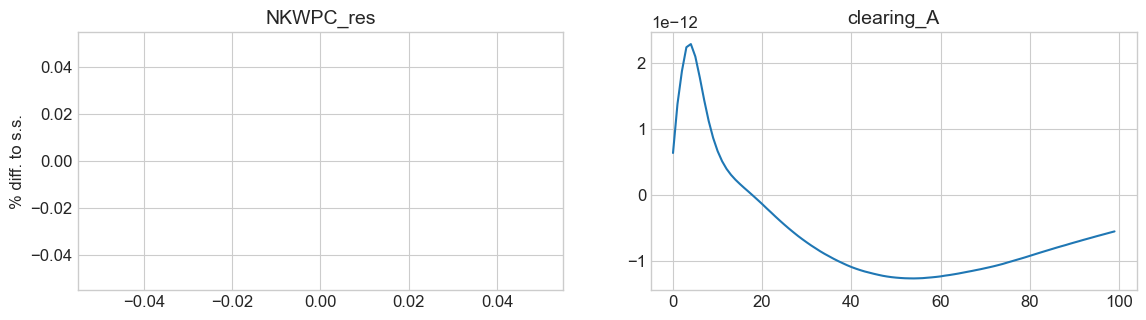

In [20]:
paths = ['C_hh','r','ra','B','tau','pi','i','q','L']

paths = ['C_hh','Y','L','tau','B','q','pi','i','ra']
#paths =['Y','A_hh','B','i','r','pi','q','C_hh','tau']
lvl_value = ['r','pi','pi_w','i','NKPWC_res','clearing_A','chi','ra']
model.show_IRFs(paths,lvl_value=lvl_value,T_max=100,ncols=3)

In [21]:
(model.path.tau[0,0]-ss.tau)/ss.tau

0.0

##### Decompose household behavior

['ra']
household problem solved along transition path in 0.1 secs
household problem simulated along transition in 0.1 secs

['L']
household problem solved along transition path in 0.1 secs
household problem simulated along transition in 0.1 secs

['tau']
household problem solved along transition path in 0.1 secs
household problem simulated along transition in 0.1 secs

['chi']
household problem solved along transition path in 0.1 secs
household problem simulated along transition in 0.1 secs

None
household problem solved along transition path in 0.1 secs
household problem simulated along transition in 0.1 secs

all
household problem simulated along transition in 0.0 secs



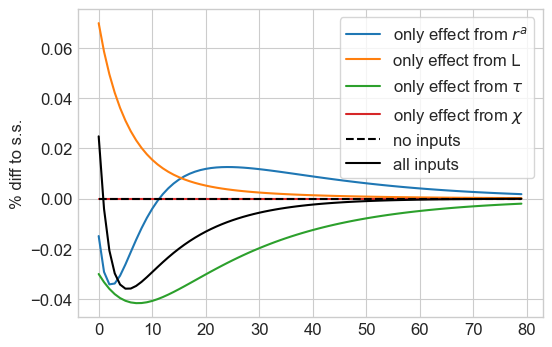

In [22]:

def decompose(model):
    T_max = 80

    fig = plt.figure(figsize=(6,4),dpi=100)
    ax = fig.add_subplot(1,1,1)
        
    i_color = 0

    input_dict = {'ra':'$r^{a}$','L':'L','tau':'$\\tau$','chi':'$\chi$'}

    for use_inputs in [['ra'],['L'],['tau'],['chi'],None,'all']:
        
        # a. compute
        print(use_inputs)
        path_alt = model.decompose_hh_path(do_print=True,use_inputs=use_inputs)
        print('')
        
        # b. plot
        if use_inputs is None:
            label = 'no inputs'
            ls = '--'
            color = 'black'
        elif use_inputs == 'all':
            label = 'all inputs'
            ls = '-'
            color = 'black'
        else:
            label = f'only effect from {input_dict[use_inputs[0]]}'
            ls = '-'
            color = colors[i_color]
            i_color += 1
            
        ax.plot((path_alt.C_hh[0,:T_max]/ss.C_hh-1)*100,ls=ls,color=color,label=label);

    ax.set_ylabel('% diff to s.s.')
    ax.legend(frameon=True);
    return fig
    
fig = decompose(model)

fig.savefig(r'output\decompose_base.png',bbox_inches='tight')

# Question 2

### shocks ###


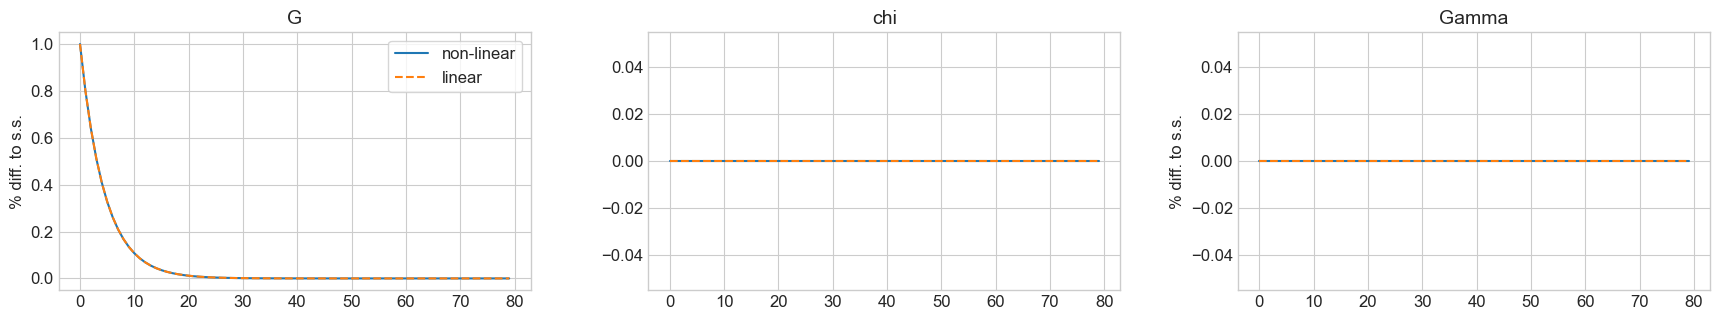


### varnames ###


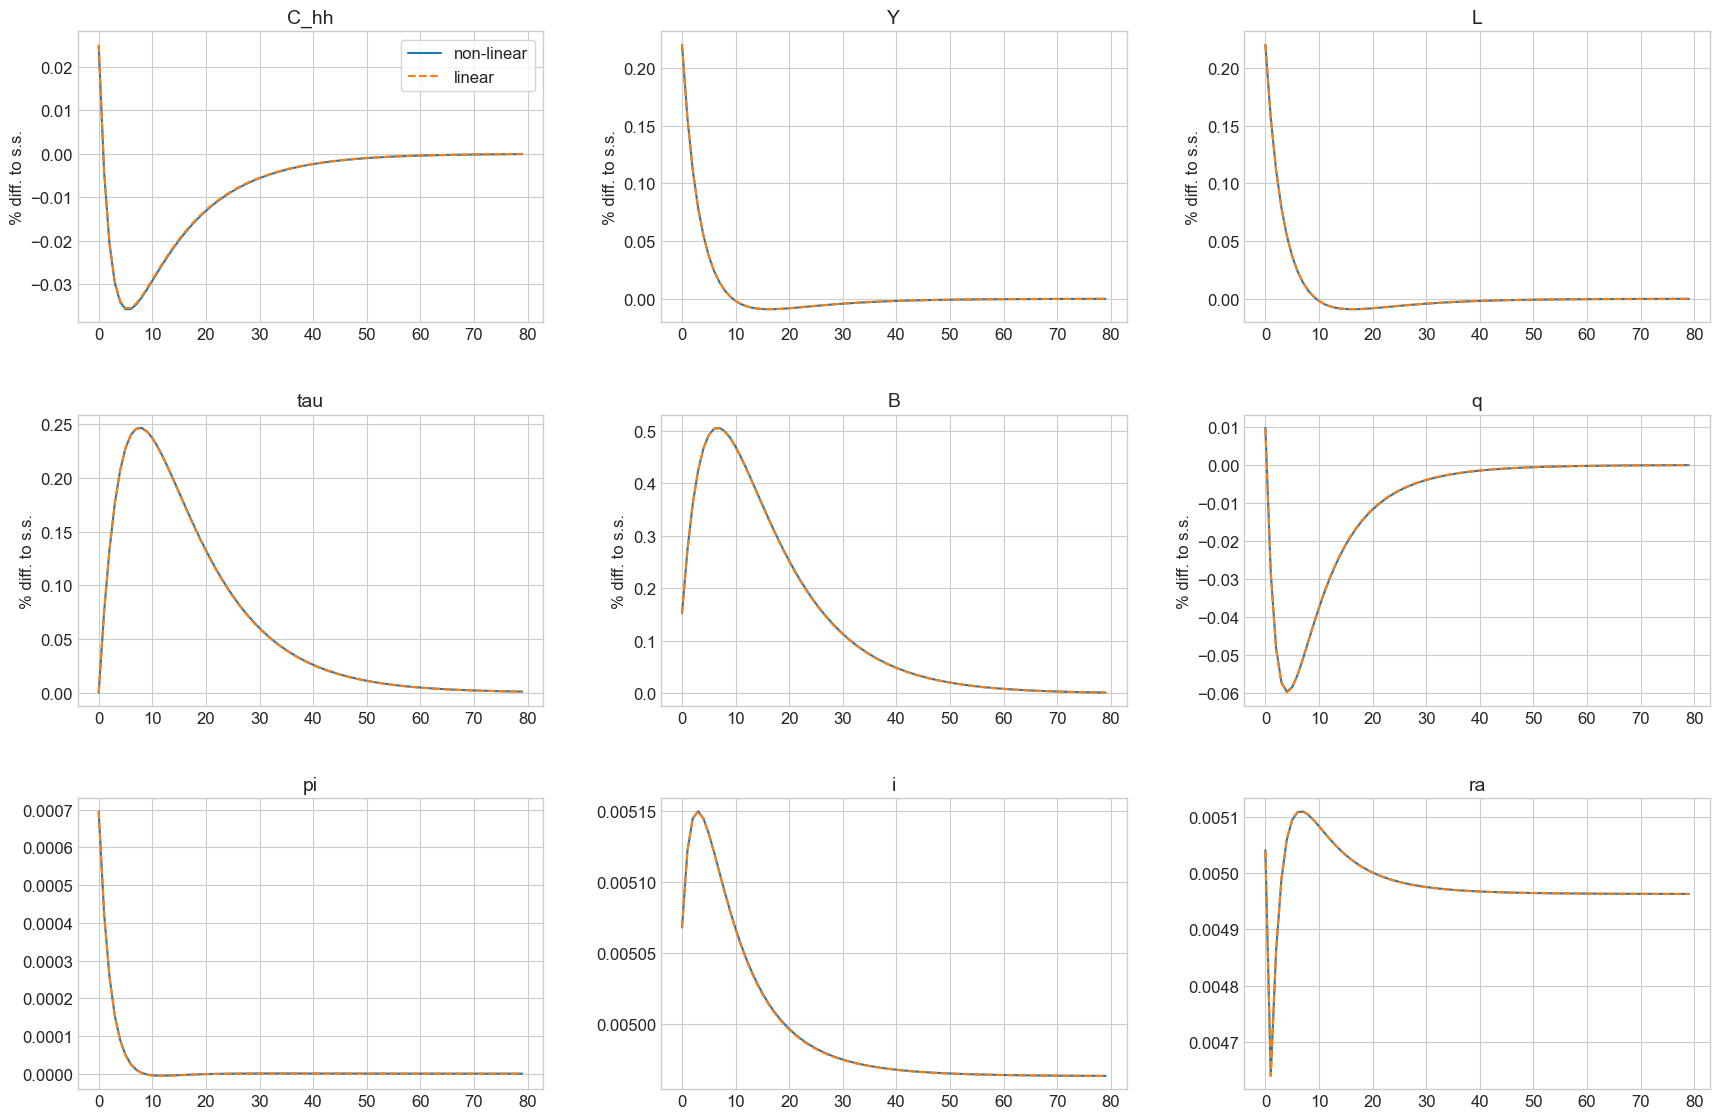


### tagets ###


c:\Users\hms467\Anaconda3\lib\site-packages\GEModelTools\figures.py:111: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(np.arange(T_max),100*(IRFvalue[:T_max]/ssvalue-1),ls='--',label='linear')
c:\Users\hms467\Anaconda3\lib\site-packages\GEModelTools\figures.py:111: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(np.arange(T_max),100*(IRFvalue[:T_max]/ssvalue-1),ls='--',label='linear')


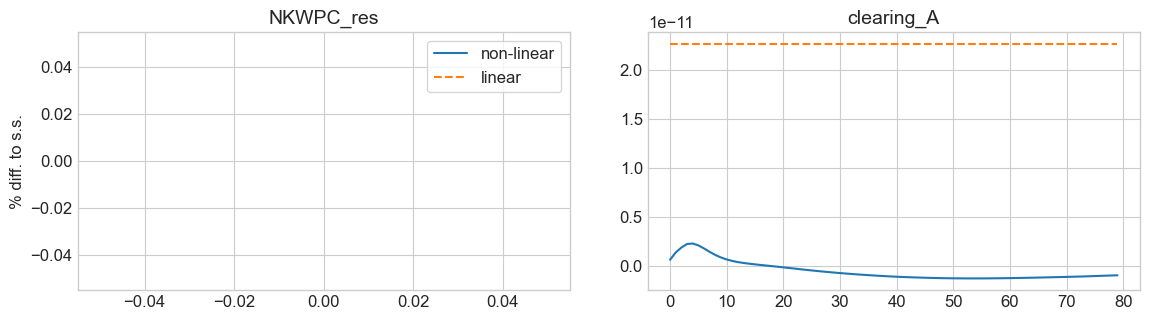

In [23]:
model.show_IRFs(paths,do_linear=True,lvl_value=lvl_value,T_max=80,ncols=3,filename=r'output\IRF_base_clearings.png')

### varnames ###


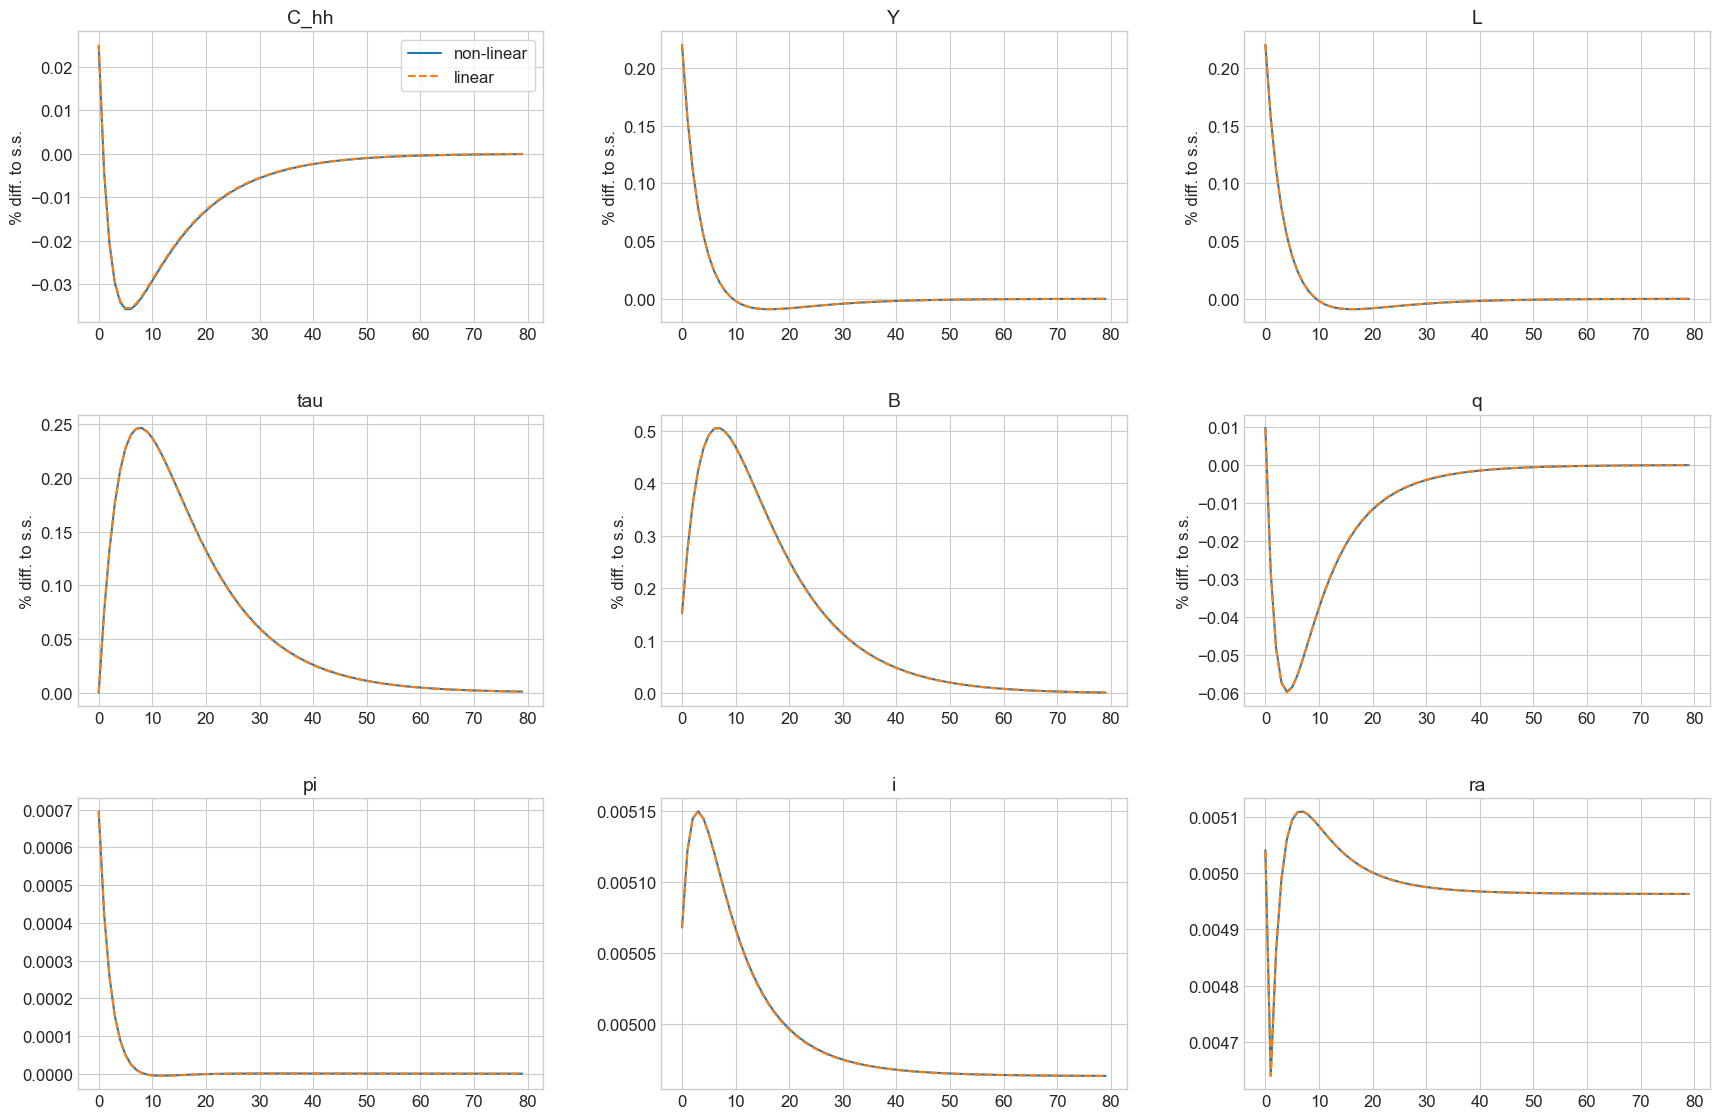

In [24]:
model.show_IRFs(paths,do_linear=True,lvl_value=lvl_value,T_max=80,ncols=3,
                do_shocks=False,do_targets=False,filename=r'output\IRF_base.png')

# Question 3

In [25]:
model_k = model.copy()
model_k.par.kappa = 0.5

In [26]:
model_k.find_ss(do_print=True)

steady state found in 3.1 secs
 r     =   0.0050
 q     =   4.8789
 qB    =   1.0000
varphi =   1.0352
beta   =   0.9767
Discrepancy in A =   0.00000000
Discrepancy in Y =   0.00000000


In [27]:
model_k.compute_jacs(do_print=False)

In [28]:
model_k.par.jump_G = 0.01*model_k.ss.G
model_k.par.rho_G = 0.8

model_k.find_transition_path(do_print=True)


finding the transition path:
 it =   0 -> max. abs. error = 1.52e-02
   8.93e-03 in NKWPC_res
   1.52e-02 in clearing_A
 it =   1 -> max. abs. error = 5.82e-05
   5.01e-05 in NKWPC_res
   5.82e-05 in clearing_A
 it =   2 -> max. abs. error = 1.55e-06
   5.03e-07 in NKWPC_res
   1.55e-06 in clearing_A
 it =   3 -> max. abs. error = 2.72e-09
   1.38e-09 in NKWPC_res
   2.72e-09 in clearing_A
 it =   4 -> max. abs. error = 4.81e-12
   4.81e-12 in NKWPC_res
   4.35e-12 in clearing_A

transition path found in 1.3 secs


In [29]:
model_k.find_IRFs(do_print=True)

linear transition path found in 0.1 secs [finding solution matrix: 0.1 secs]


### shocks ###


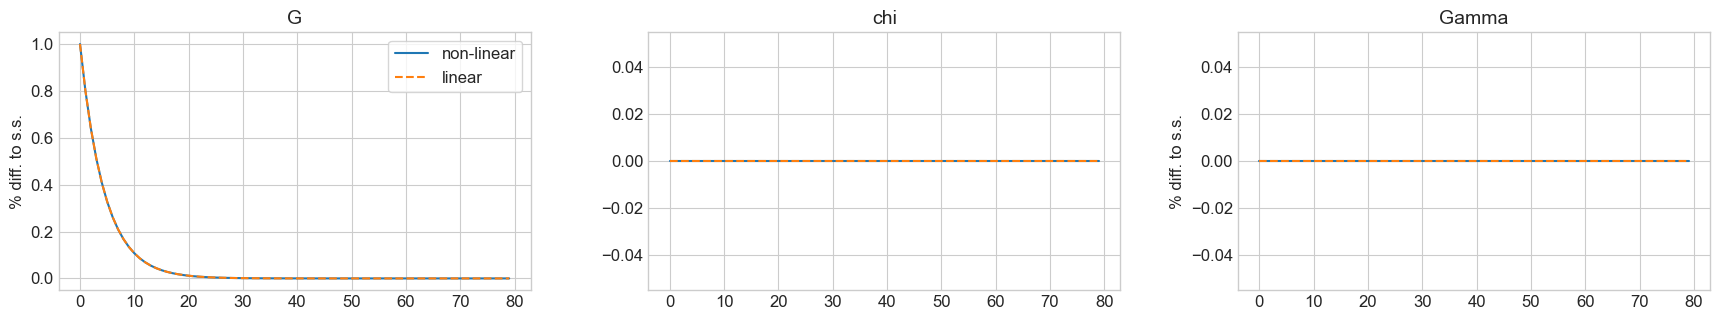


### varnames ###


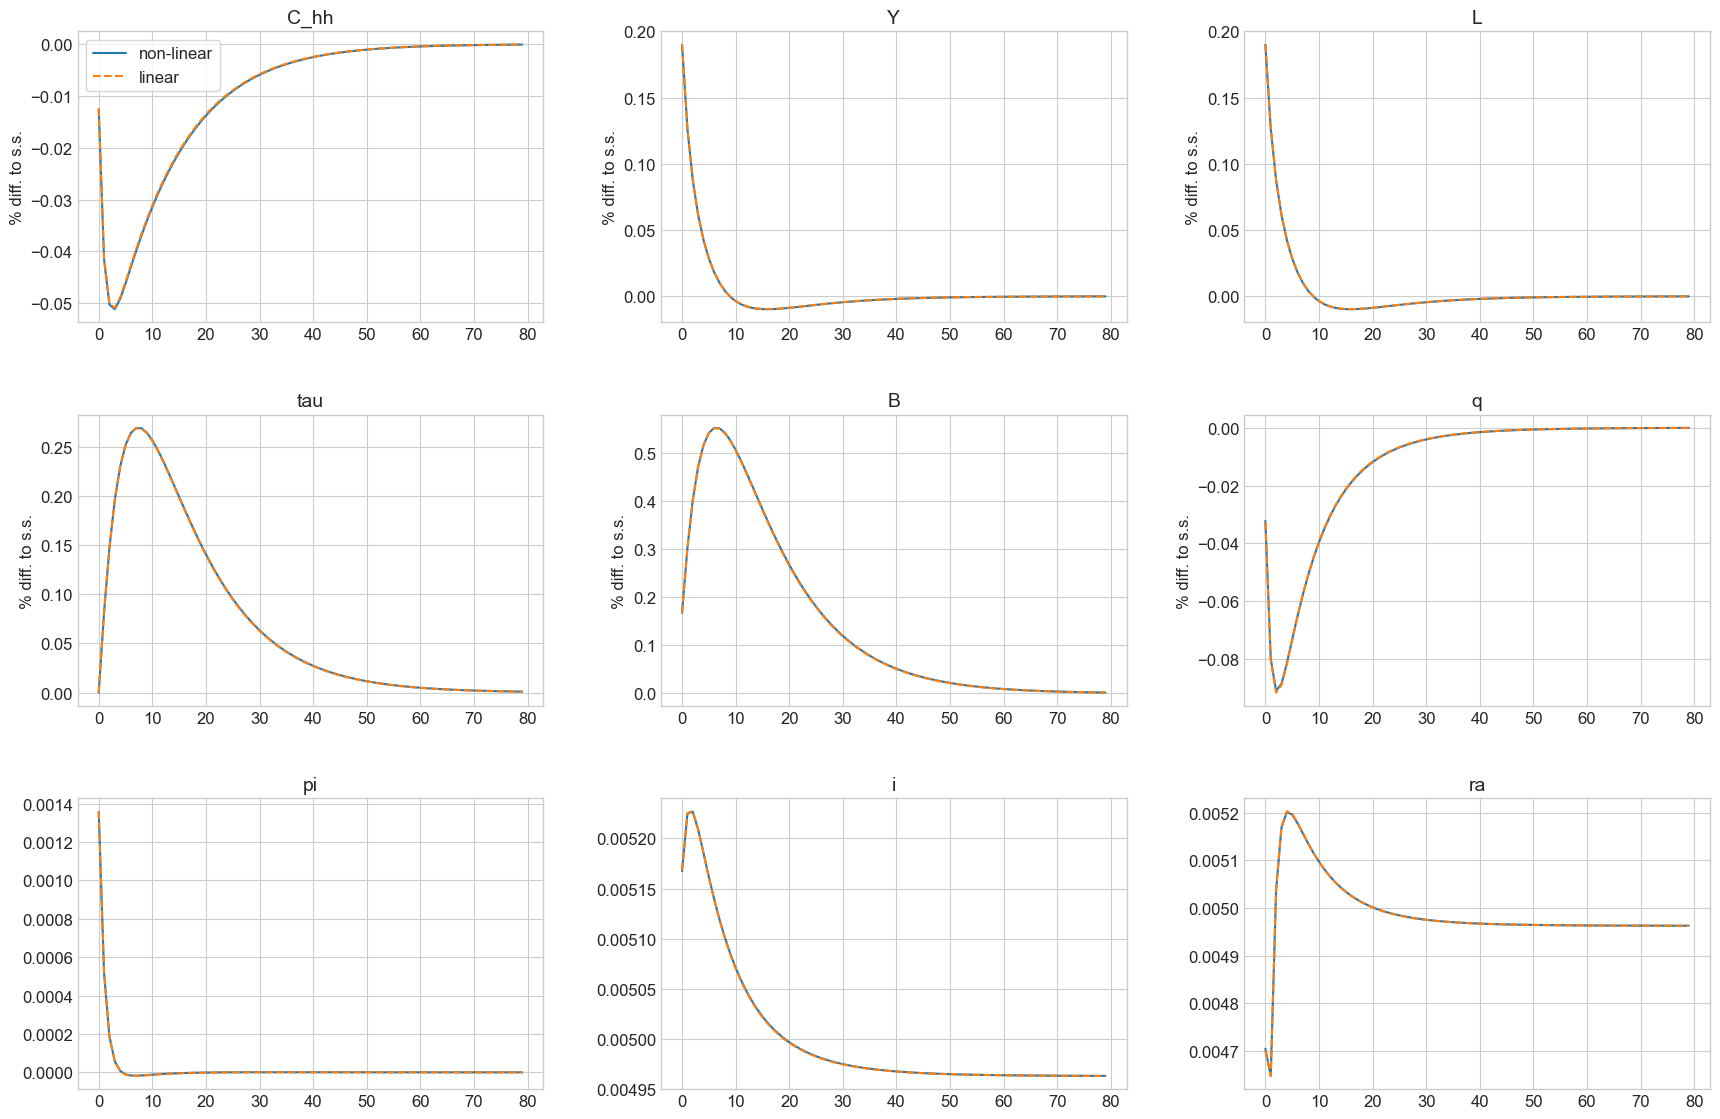


### tagets ###


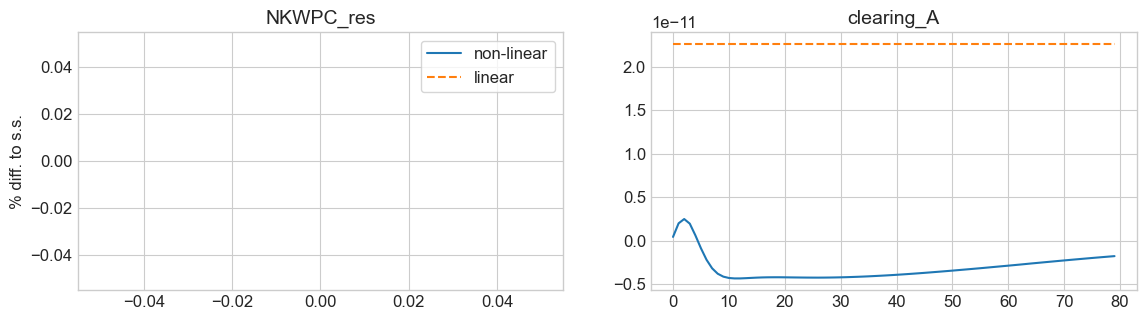

In [30]:
model_k.show_IRFs(paths,lvl_value=lvl_value,T_max=80,ncols=3,do_linear=True)

### varnames ###


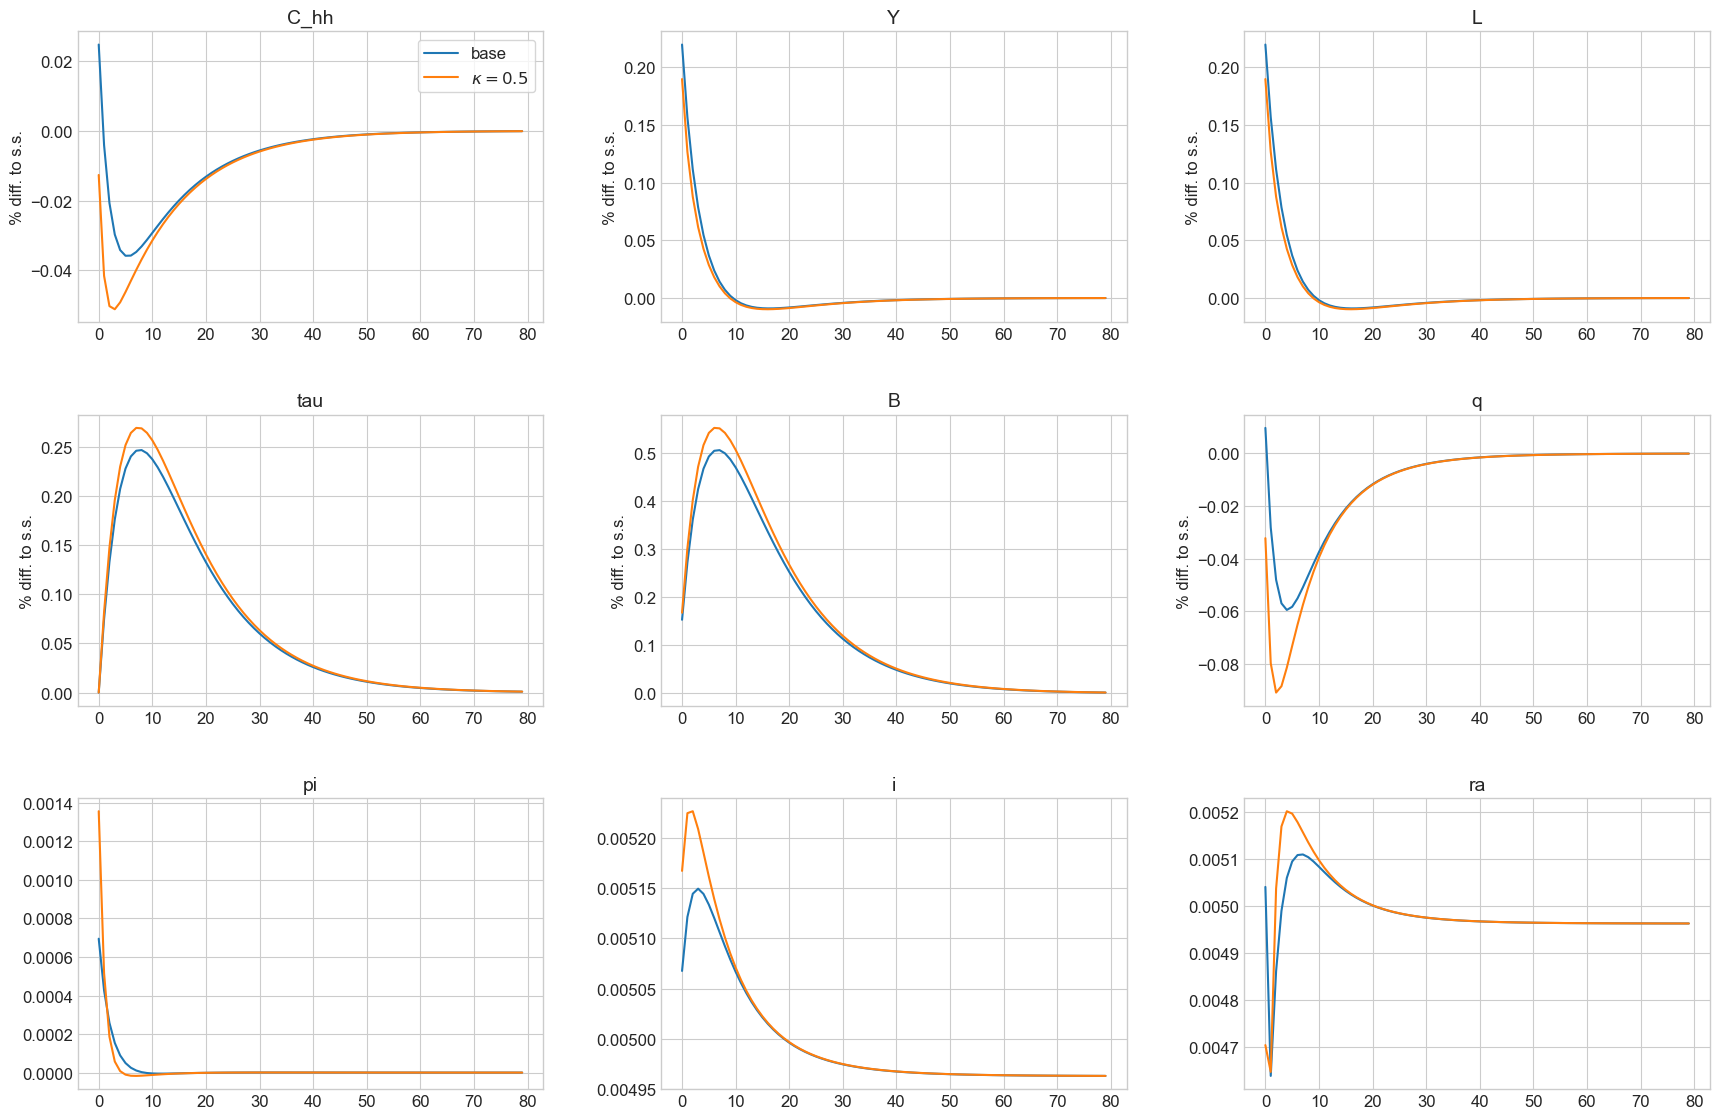

In [31]:
model.compare_IRFs([model,model_k],['base','$\kappa=0.5$'], paths,lvl_value=lvl_value,T_max=80,ncols=3,
                    do_shocks= False, do_targets=False,filename='output\IRF_kappa.png')

['ra']
household problem solved along transition path in 0.1 secs
household problem simulated along transition in 0.1 secs

['L']
household problem solved along transition path in 0.1 secs
household problem simulated along transition in 0.1 secs

['tau']
household problem solved along transition path in 0.2 secs
household problem simulated along transition in 0.1 secs

['chi']
household problem solved along transition path in 0.1 secs
household problem simulated along transition in 0.1 secs

None
household problem solved along transition path in 0.1 secs
household problem simulated along transition in 0.1 secs

all
household problem simulated along transition in 0.1 secs



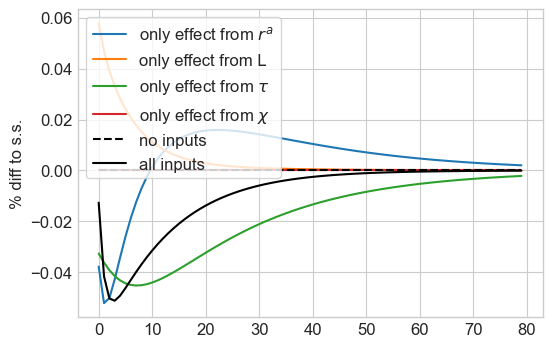

In [38]:
fig = decompose(model_k)

# Question 4

In [32]:
### Compare shocks
model_chi = model.copy()

In [33]:
model_chi.par.jump_G = 0.0
model_chi.par.rho_G = 0.0
model_chi.par.jump_chi = 0.01 * ss.G
model_chi.par.rho_chi = 0.8
print(model_chi.par.jump_chi)

model_chi.find_transition_path(do_print=True)

0.002
finding the transition path:
 it =   0 -> max. abs. error = 1.84e-02
   2.03e-03 in NKWPC_res
   1.84e-02 in clearing_A
 it =   1 -> max. abs. error = 1.03e-04
   1.50e-05 in NKWPC_res
   1.03e-04 in clearing_A
 it =   2 -> max. abs. error = 2.15e-06
   1.52e-07 in NKWPC_res
   2.15e-06 in clearing_A
 it =   3 -> max. abs. error = 3.38e-09
   3.97e-10 in NKWPC_res
   3.38e-09 in clearing_A
 it =   4 -> max. abs. error = 3.36e-12
   9.41e-13 in NKWPC_res
   3.36e-12 in clearing_A

transition path found in 1.5 secs


In [34]:
model_chi.find_IRFs(do_print=True)

linear transition path found in 0.1 secs [finding solution matrix: 0.1 secs]


### shocks ###


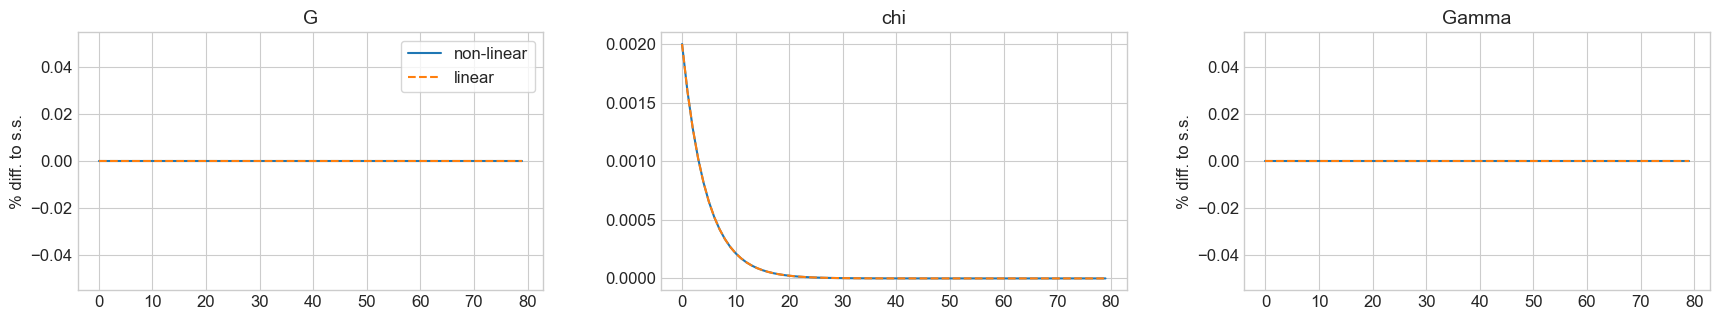


### varnames ###


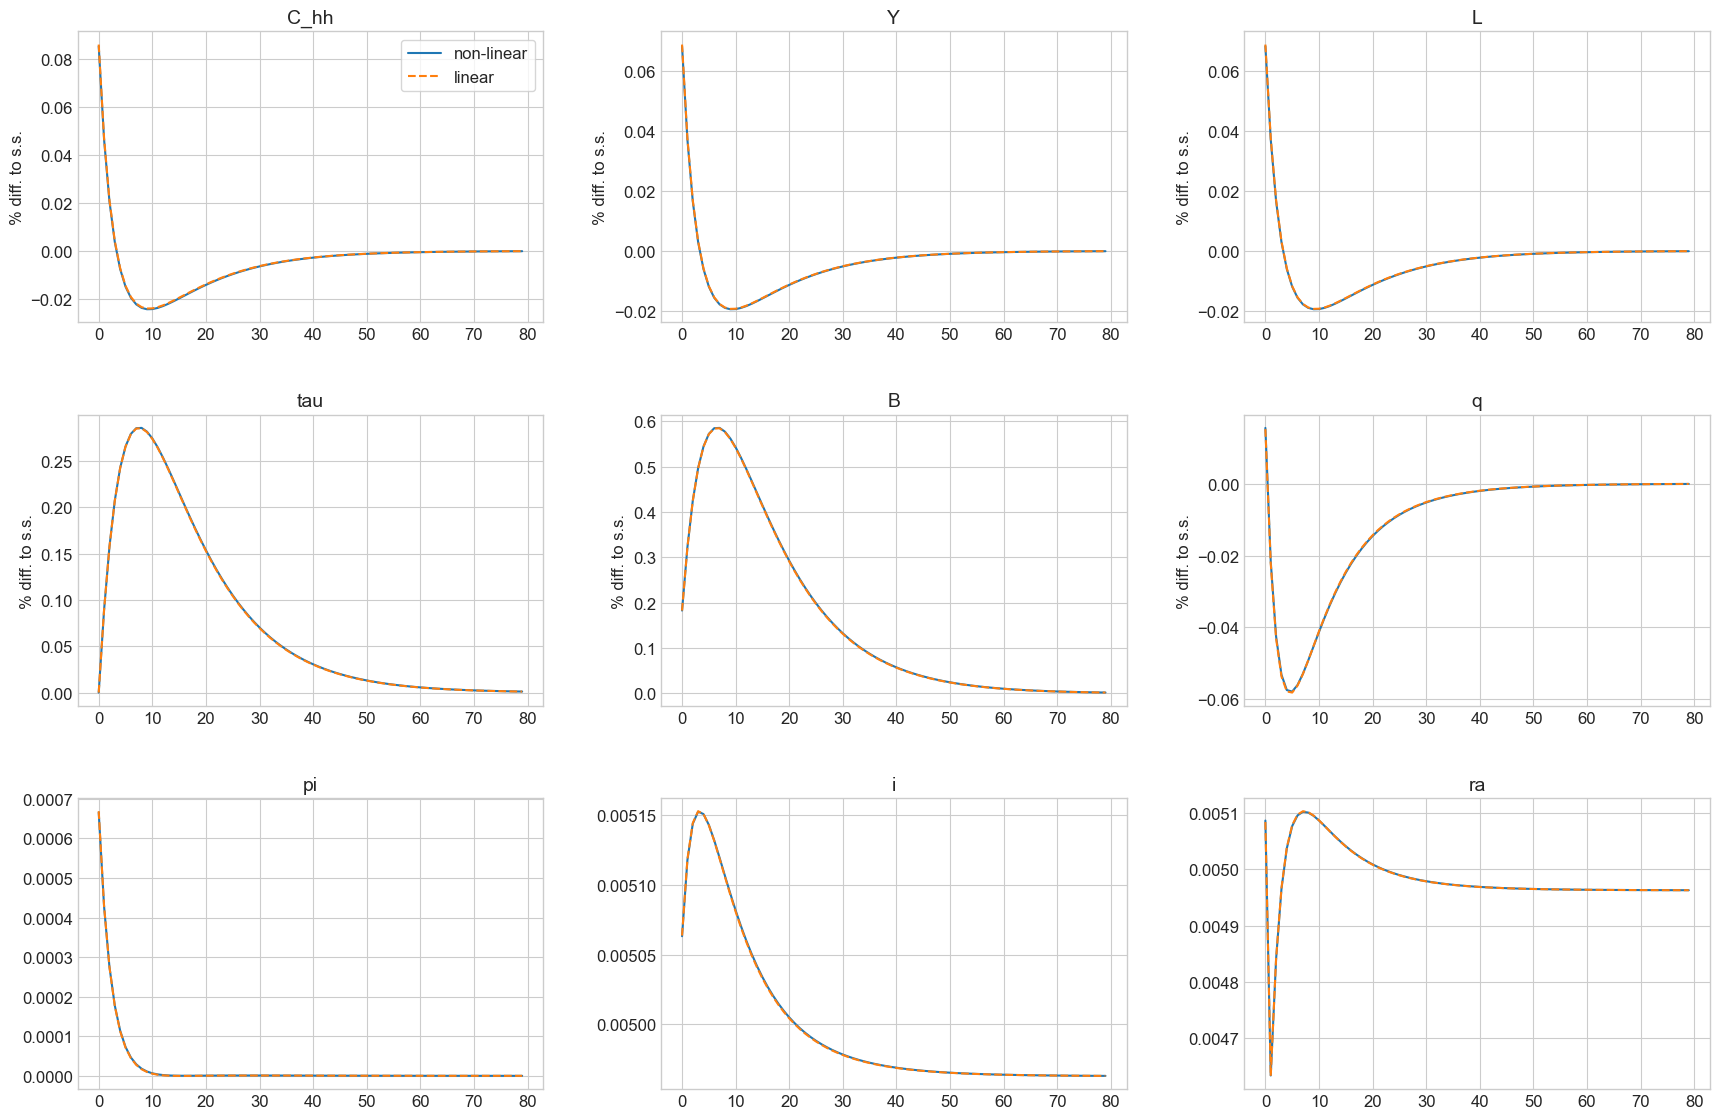


### tagets ###


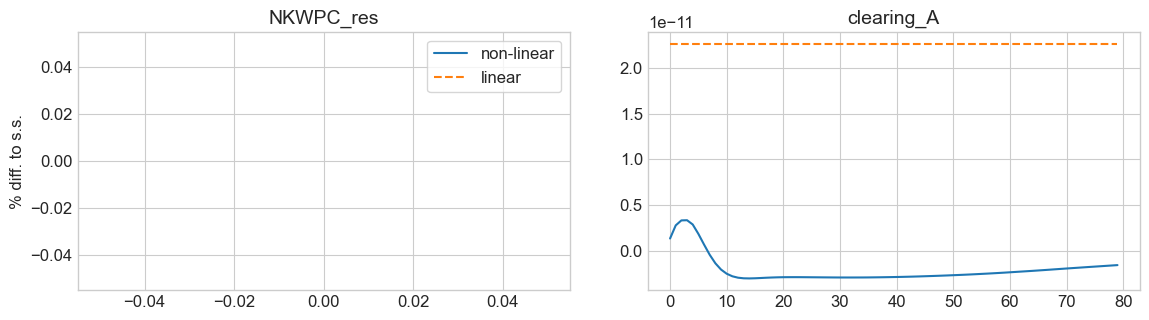

In [35]:
model_chi.show_IRFs(paths,lvl_value=lvl_value,T_max=80,ncols=3,do_linear=True)

### varnames ###


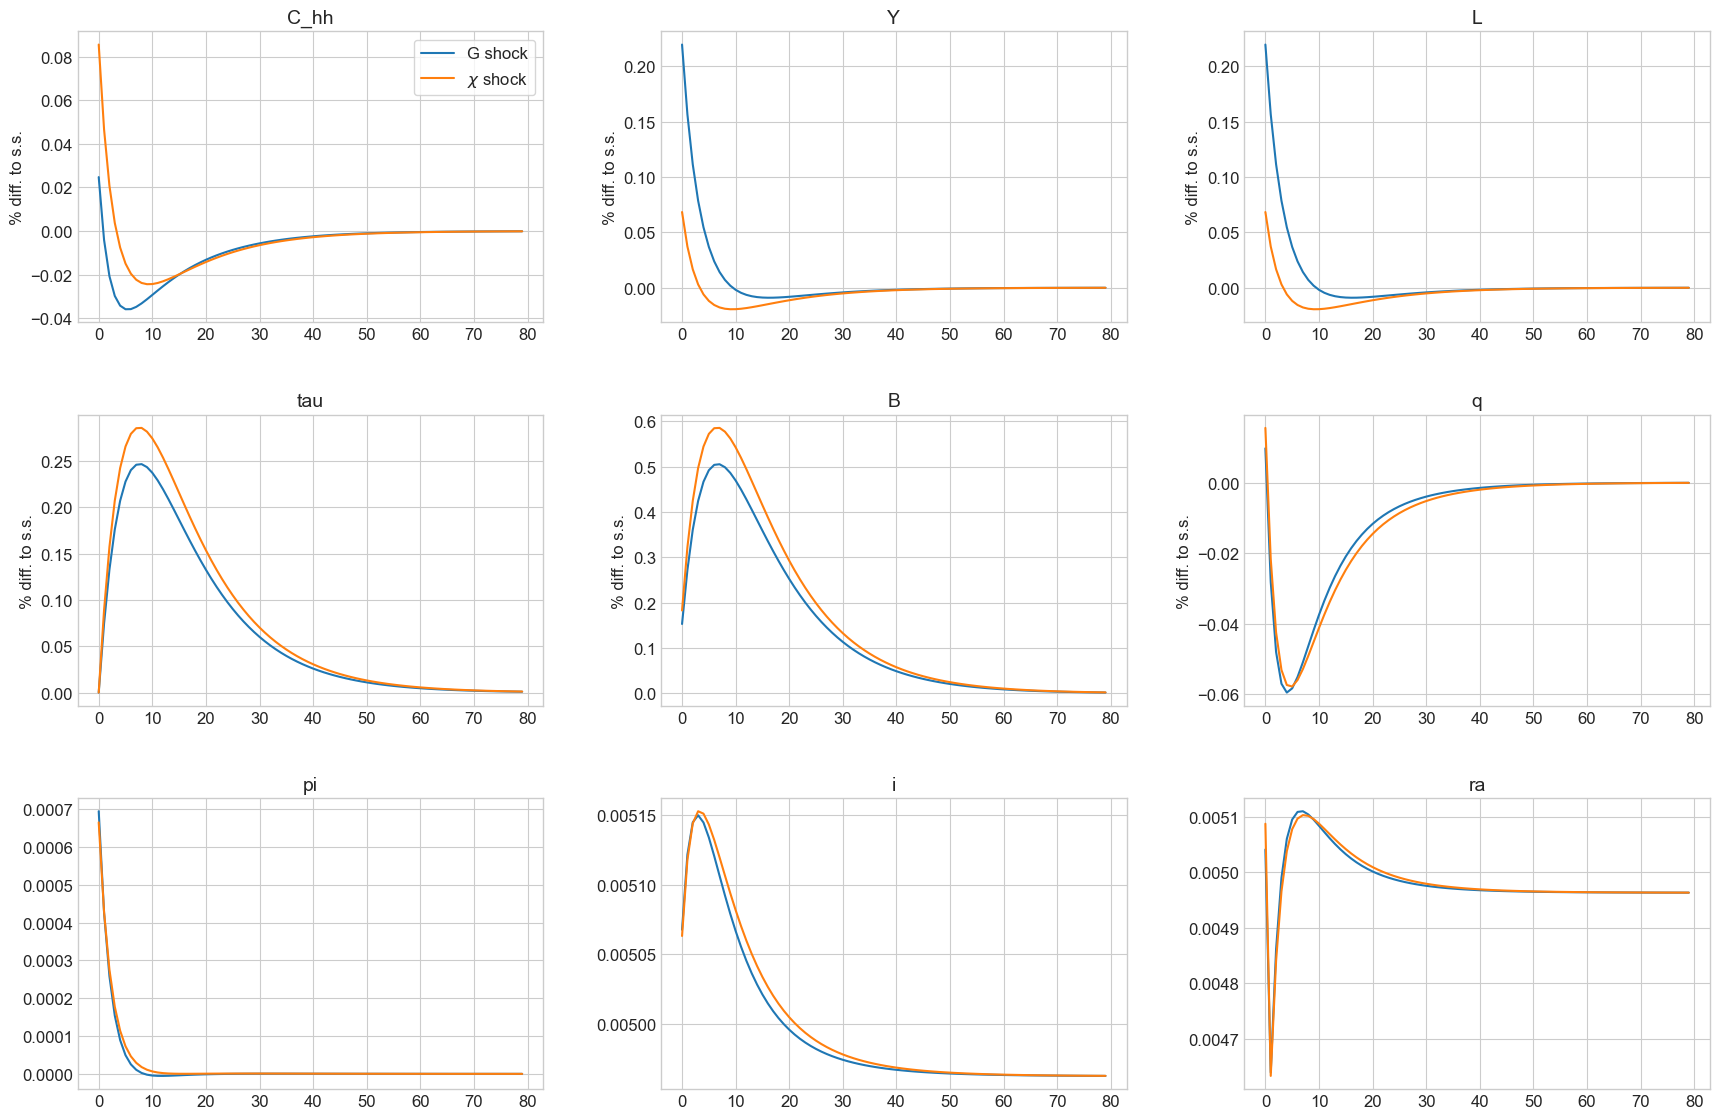

In [36]:
model.compare_IRFs([model,model_chi],['G shock','$\chi$ shock'],paths,lvl_value=lvl_value,T_max=80,ncols=3,
                do_shocks=False,do_targets=False,filename=r'output\IRF_base_chi.png')

['ra']
household problem solved along transition path in 0.2 secs
household problem simulated along transition in 0.1 secs

['L']
household problem solved along transition path in 0.1 secs
household problem simulated along transition in 0.1 secs

['tau']
household problem solved along transition path in 0.1 secs
household problem simulated along transition in 0.1 secs

['chi']
household problem solved along transition path in 0.1 secs
household problem simulated along transition in 0.1 secs

None
household problem solved along transition path in 0.1 secs
household problem simulated along transition in 0.1 secs

all
household problem simulated along transition in 0.1 secs



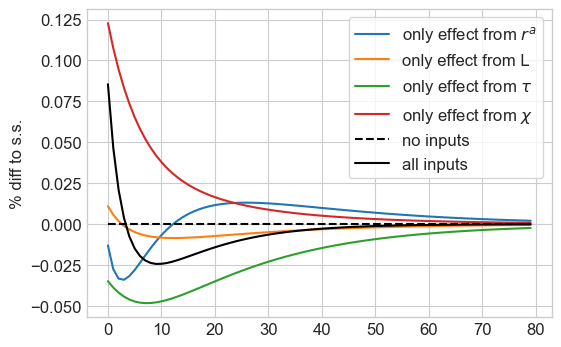

In [37]:
fig = decompose(model_chi)

fig.savefig(r'output\decompose_chi.png',bbox_inches='tight')

In [70]:
ss = model.ss
par = model.par 

MPC = np.zeros(ss.D.shape)
dc = (ss.c[:,:,1:]-ss.c[:,:,:-1])
dm = (1+model.ss.r)*par.a_grid[np.newaxis,np.newaxis,1:]-(1+model.ss.r)*par.a_grid[np.newaxis,np.newaxis,:-1]
MPC[:,:,:-1] = dc/dm
MPC[:,:,-1] = MPC[:,:,-2] # assuming constant MPC at end
mean_MPC = np.sum(MPC*ss.D)

print(f'mean MPC: {mean_MPC:.3f}')

mean MPC: 0.293


In [75]:
path = model.path
par = model.par 

MPC = np.zeros(path.D[0].shape)
dc = (path.c[0,:,:,1:]-path.c[0,:,:,:-1])
dm = (1+model.path.r[0,0])*par.a_grid[np.newaxis,np.newaxis,1:]-(1+model.path.r[0,0])*par.a_grid[np.newaxis,np.newaxis,:-1]
MPC[:,:,:-1] = dc/dm
MPC[:,:,-1] = MPC[:,:,-2] # assuming constant MPC at end
mean_MPC = np.sum(MPC*path.D[0])

print(f'mean MPC: {mean_MPC:.3f}')

mean MPC: 0.292
